In [ ]:
#http://qiita.com/hikobotch/items/018808ef795061176824

In [34]:
# -*- coding: utf-8 -*-

# とりあえず片っ端からimport
import numpy as np
import chainer
# from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import cuda, Function, Variable, optimizers, serializers, utils
from chainer import report, training, Chain, datasets, iterators, optimizers
# from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
import time
from matplotlib import pyplot as plt
%matplotlib inline


In [35]:
# データ
def get_dataset(N):
    x = np.linspace(0, 2 * np.pi, N)
    y = np.sin(x)
    return x, y
print(get_dataset(10)[0].shape)
print(get_dataset(10)[1].shape)

(10,)
(10,)


In [36]:
# FFNN
class FFNN_Model(chainer.Chain):
    def __init__(self, n_units=10):
        super(FFNN_Model, self).__init__(
             l1=L.Linear(1, n_units),
             l2=L.Linear(n_units, n_units),
             l3=L.Linear(n_units, 1))

    def __call__(self, x_data, y_data):
        x = Variable(x_data.astype(np.float32).reshape(len(x_data),1)) # Variableオブジェクトに変換
        y = Variable(y_data.astype(np.float32).reshape(len(y_data),1)) # Variableオブジェクトに変換
        return F.mean_squared_error(self.predict(x), y)

    def  predict(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = self.l3(h2)
        return h3

    def get_predata(self, x):
        return self.predict(Variable(x.astype(np.float32).reshape(len(x),1))).data


x_train  (100,)
start...
epoch: 10/500 train loss: 0.27887553721666336 test loss: 0.26902079582214355


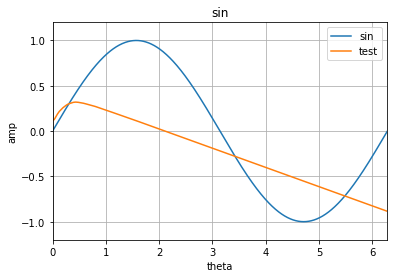

epoch: 20/500 train loss: 0.17569169104099275 test loss: 0.18585434556007385
epoch: 30/500 train loss: 0.18419688232243062 test loss: 0.15769146382808685
epoch: 40/500 train loss: 0.16028203144669534 test loss: 0.1466454416513443
epoch: 50/500 train loss: 0.17861241474747658 test loss: 0.15773622691631317
epoch: 60/500 train loss: 0.23314867317676544 test loss: 0.15998779237270355
epoch: 70/500 train loss: 0.1757053542882204 test loss: 0.14303015172481537
epoch: 80/500 train loss: 0.1785631522536278 test loss: 0.1431102156639099
epoch: 90/500 train loss: 0.1678842432796955 test loss: 0.15425321459770203
epoch: 100/500 train loss: 0.15657075941562654 test loss: 0.14175380766391754
epoch: 110/500 train loss: 0.14694690145552158 test loss: 0.13667264580726624
epoch: 120/500 train loss: 0.14618446864187717 test loss: 0.1646394282579422
epoch: 130/500 train loss: 0.14545469656586646 test loss: 0.13293638825416565
epoch: 140/500 train loss: 0.1761254720389843 test loss: 0.13584430515766144
e

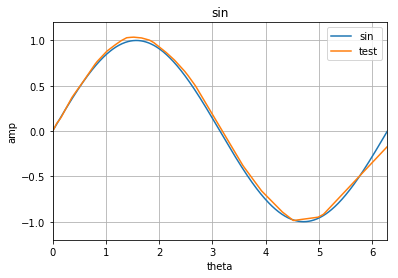

end
実行時間: 10sec


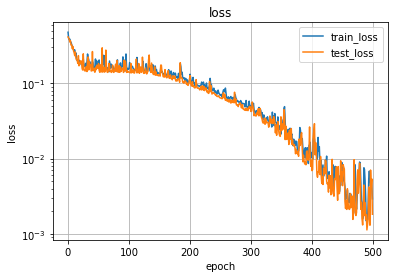

In [37]:

# main
if __name__ == "__main__":

    # 学習データ
    N = 100
    x_train, y_train = get_dataset(N)

    # テストデータ
    N_test = 900
    x_test, y_test = get_dataset(N_test)

    # 学習パラメータ
    batchsize = 10
    n_epoch = 500
    n_units = 100

    print("x_train ", x_train.shape)
    
    # モデル作成
    model = FFNN_Model(n_units)
    optimizer = optimizers.Adam()
    optimizer.setup(model)

    # 学習ループ
    train_losses =[]
    test_losses =[]
    print("start...")
    start_time = time.time()
    #n_epochが500だと500回まわる
    for epoch in range(1, n_epoch + 1):

        # training
        perm = np.random.permutation(N)
        sum_loss = 0
        #batchsizeが100個のデータに対して10個ずつまわる
        for i in range(0, N, batchsize):
            x_batch = x_train[perm[i:i + batchsize]]
            y_batch = y_train[perm[i:i + batchsize]]

            model.zerograds()
            loss = model(x_batch,y_batch)
            sum_loss += loss.data * batchsize
            loss.backward()
            optimizer.update()

        average_loss = sum_loss / N
        train_losses.append(average_loss)

        # test
        loss = model(x_test,y_test)
        test_losses.append(loss.data)

        # 学習過程を出力
        if epoch % 10 == 0:
            print("epoch: {}/{} train loss: {} test loss: {}".format(epoch, n_epoch, average_loss, loss.data))

        # 学習結果のグラフ作成
        if epoch in [10, 500]:
            theta = np.linspace(0, 2 * np.pi, N_test)
            sin = np.sin(theta)
            test = model.get_predata(theta)
            plt.plot(theta, sin, label = "sin")
            plt.plot(theta, test, label = "test")
            plt.legend()
            plt.grid(True)
            plt.xlim(0, 2 * np.pi)
            plt.ylim(-1.2, 1.2)
            plt.title("sin")
            plt.xlabel("theta")
            plt.ylabel("amp")
            plt.show()
#             plt.savefig("fig/fig_sin_epoch{}.png".format(epoch)) # figフォルダが存在していることを前提
            plt.clf() #グラフ初期化

    print("end")

    interval = int(time.time() - start_time)
    print("実行時間: {}sec".format(interval))


    # 誤差のグラフ作成
    plt.plot(train_losses, label = "train_loss")
    plt.plot(test_losses, label = "test_loss")
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.title("loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
#     plt.savefig("fig/fig_loss.png") # figフォルダが存在していることを前提
#     plt.clf()
    plt.show()
